In [1]:
### Training with PyTorch
#### Link: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5,))
    ]
)

# Create dataset for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(
    '/home/irikos/Work/datasets/pytorch_tutorials', 
    train=True, 
    transform=transform, 
    download=True
    )
validation_set = torchvision.datasets.FashionMNIST(
    '/home/irikos/Work/datasets/pytorch_tutorials', 
    train=False,
    transform=transform, 
    download=True
    )

# Create data loaders for our datasets; shuffle for training, but not for validation

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


In [6]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(np.img, (1, 2, 0)))

Shirt  Bag  Bag  Shirt


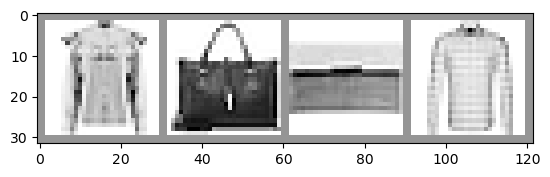

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### The Model

In [9]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = GarmentClassifier()

### Loss Function

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)

# Represents the correct class among the 10 being test
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8940, 0.9775, 0.4562, 0.3596, 0.2612, 0.3066, 0.5181, 0.4128, 0.2227,
         0.4450],
        [0.9792, 0.0227, 0.2723, 0.2123, 0.7545, 0.8512, 0.7937, 0.7742, 0.6917,
         0.6355],
        [0.4610, 0.6087, 0.3544, 0.1494, 0.3163, 0.8499, 0.7324, 0.8462, 0.5188,
         0.9696],
        [0.1202, 0.7510, 0.1000, 0.0653, 0.0627, 0.5525, 0.4715, 0.0234, 0.1801,
         0.1646]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.31449556350708


### Optimizer

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The training loop

In [14]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0

    # Here, we use enumerate(training_loader) instead of iter(training_loader) so we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust the learning weights
        optimizer.step()

        # Gather data and report
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/irikos/Work/Practice/DeepLearning/output/runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.0
  batch 2000 loss: 0.0
  batch 3000 loss: 0.0
  batch 4000 loss: 0.0
  batch 5000 loss: 0.0
  batch 6000 loss: 0.0
  batch 7000 loss: 0.0
  batch 8000 loss: 0.0
  batch 9000 loss: 0.0
  batch 10000 loss: 0.0
  batch 11000 loss: 0.0
  batch 12000 loss: 0.0
  batch 13000 loss: 0.0
  batch 14000 loss: 0.0
  batch 15000 loss: 0.0
LOSS train 0.0 valid 0.3840884566307068
EPOCH 2:
  batch 1000 loss: 0.0
  batch 2000 loss: 0.0
  batch 3000 loss: 0.0
  batch 4000 loss: 0.0
  batch 5000 loss: 0.0
  batch 6000 loss: 0.0
  batch 7000 loss: 0.0
  batch 8000 loss: 0.0
  batch 9000 loss: 0.0
  batch 10000 loss: 0.0
  batch 11000 loss: 0.0
  batch 12000 loss: 0.0
  batch 13000 loss: 0.0
  batch 14000 loss: 0.0
  batch 15000 loss: 0.0
LOSS train 0.0 valid 0.33900269865989685
EPOCH 3:
  batch 1000 loss: 0.0
  batch 2000 loss: 0.0
  batch 3000 loss: 0.0
  batch 4000 loss: 0.0
  batch 5000 loss: 0.0
  batch 6000 loss: 0.0
  batch 7000 loss: 0.0
  batch 8000 loss: 0.0
  batc

In [19]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))

NameError: name 'PATH' is not defined